## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import requests

from cv2 import rectangle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
import torch

In [4]:
import tensorflow as tf
BATCH_SIZE = 16

2025-08-29 10:29:07.390828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756456147.401805 2158650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756456147.405204 2158650 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-29 10:29:07.416616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor, resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wget "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640" -O "img.jpg"

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/frederic.boisnard/.wget-hsts'. HSTS will be disabled.
--2025-08-29 10:29:13--  https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640
Resolving unsplash.com (unsplash.com)... 151.101.65.181, 151.101.1.181, 151.101.193.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.65.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640 [following]
--2025-08-29 10:29:14--  https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640
Resolving images.unsplash.com (images.unsplash.com)... 199.232.82.208, 2a04:4e42:54::720
Connecting to images.unsplash.com (images.unsplash.com)|199.2

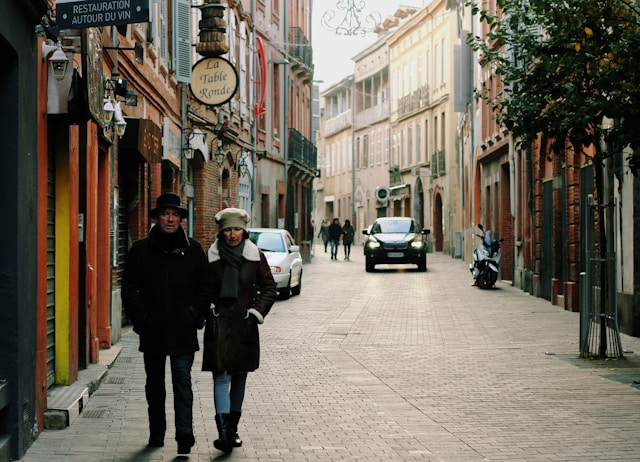

In [7]:
# street from Toulouse
url = "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640"

# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("img.jpg")

# get a torch tensor
torch_image = to_tensor(image)

# batch the image
visualizable_torch_inputs = torch_image.unsqueeze(0)

# visualize image
to_pil_image(torch_image)

In [8]:
torch_image.shape

torch.Size([3, 462, 640])

In [9]:
visualizable_torch_inputs.shape

torch.Size([1, 3, 462, 640])

## Load DETR

In [10]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

nb_classes = len(CLASSES)
print(nb_classes)

91


In [11]:
import torchvision.transforms as T

In [12]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()

Using cache found in /home/frederic.boisnard/.cache/torch/hub/facebookresearch_detr_main
/home/frederic.boisnard/virtualenvs/detr2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frederic.boisnard/virtualenvs/detr2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [14]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [15]:
# mean-std normalize the input image (batch-size: 1)
img = transform(image).unsqueeze(0)

# propagate through the model
outputs = model(img)

In [16]:
outputs['pred_logits'].shape, outputs['pred_boxes'].shape

(torch.Size([1, 100, 92]), torch.Size([1, 100, 4]))

1 image, 100 boites, 92 logits (1 hot) & 4 box coordonnates

## Obj Detection Wrapper

In [17]:
from boxes_model_wrapper import DetrBoxesModelWrapper

od_model = DetrBoxesModelWrapper(model, nb_classes=nb_classes)
results = od_model(visualizable_torch_inputs)

In [18]:
results.shape

torch.Size([1, 100, 96])

In [19]:
r = results[0]
r.shape

torch.Size([100, 96])

In [20]:
r[:, 4].argmax()

tensor(43)

In [21]:
CLASSES[1]

'person'

## Visu f()

In [22]:
from display_image_with_boxes import display_image_with_boxes
from xplique.utils_functions.box_manager import BoxFormat

## Visu DETR

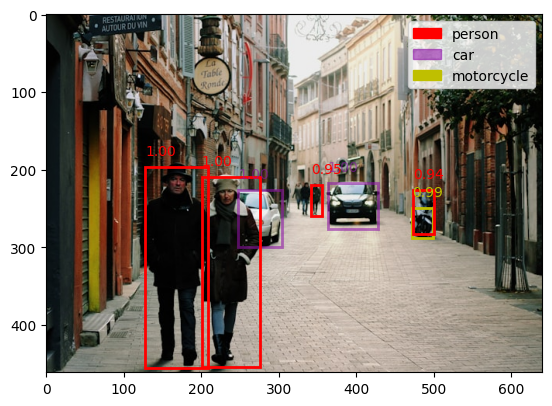

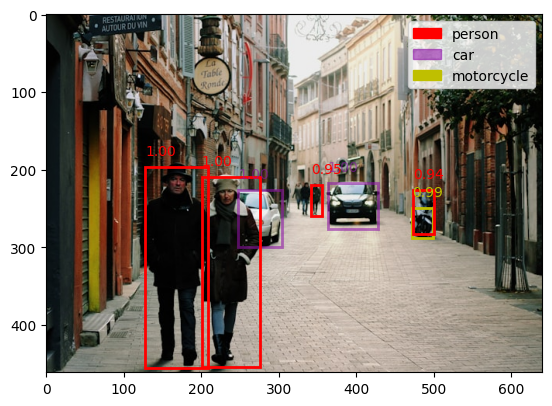

In [23]:

# class labels to color mapping
label_to_color = {'person': 'r',
                  'car': "#8F15A894",
                  'motorcycle': 'y'}

display_image_with_boxes(image, results[0].cpu().detach(), BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.9)

## DetrFormatter

In [24]:
results = model(visualizable_torch_inputs)

In [25]:
results

{'pred_logits': tensor([[[-14.6722,   1.8721,  -1.2575,  ...,  -4.8850,  -4.8518,   7.2869],
          [-13.5736,   8.5294,   0.1690,  ..., -11.1314,  -5.7762,   6.4045],
          [-15.6909,   1.7041,  -2.4899,  ...,  -6.0063,  -4.4516,   7.8857],
          ...,
          [-15.4286,   5.7635,  -0.4969,  ..., -11.1302,  -7.5297,   7.5447],
          [-11.1115,   3.2051,  -0.2659,  ..., -11.5686,  -8.2683,   5.0743],
          [-15.0981,   5.5527,   0.0358,  ..., -10.3931,  -6.9739,   7.0771]]],
        grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.2214, 0.6590, 0.0371, 0.1740],
          [0.5129, 0.5183, 0.0183, 0.0804],
          [0.3031, 0.6736, 0.0564, 0.1841],
          [0.5400, 0.5019, 0.0149, 0.0298],
          [0.4891, 0.5111, 0.0170, 0.0605],
          [0.4304, 0.5692, 0.0869, 0.1594],
          [0.4984, 0.5188, 0.0193, 0.0832],
          [0.3295, 0.7091, 0.0309, 0.0915],
          [0.3157, 0.5157, 0.0272, 0.0865],
          [0.3070, 0.5290, 0.0300, 0.0727],
          

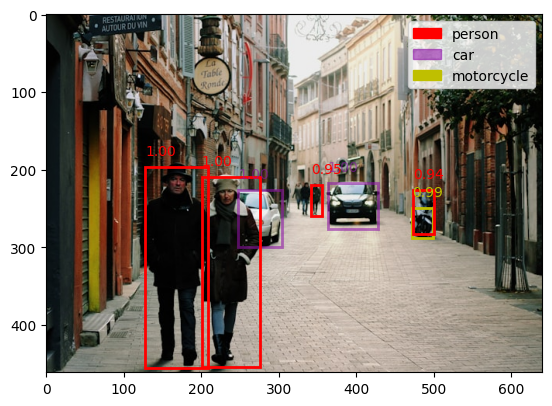

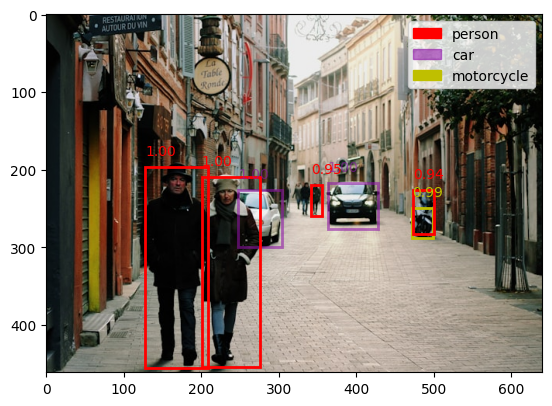

In [26]:
from xplique.concepts.latent_extractor import LatentExtractor, TorchLatentExtractor, DetrBoxFormatter
detr_and_formatter = T.Compose([
    model,
    DetrBoxFormatter()
])
results2 = detr_and_formatter(visualizable_torch_inputs)
display_image_with_boxes(image, results2[0].cpu().detach(), BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.9)

In [ ]:
# 4/ 0

ZeroDivisionError: division by zero

## Test saliency

In [28]:
from xplique.wrappers import TorchWrapper

from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator

In [29]:
# torch_wrapped_model = od_model
from xplique.wrappers import TorchWrapper
od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [30]:
import xplique
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [31]:
# Test scores
# inputs = images_preprocessed[current_image_index:current_image_index+1].permute(0, 2, 3, 1)
# inputs_torch = torch.Tensor(inputs)
# targets = format_annotations(annotations_for_images[current_image_index:current_image_index+3], nb_classes)
# targets = formated_annotations[current_image_index:current_image_index+1]
inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
targets = torch_wrapped_model(inputs)

I0000 00:00:1756456173.098418 2158650 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5971 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_inputs = self.torch.Tensor(np_inputs)


RuntimeError: Exception encountered when calling TorchWrapper.call().

[1mA view was created in no_grad mode and is being modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.[0m

Arguments received by TorchWrapper.call():
  • inputs=tf.Tensor(shape=(1, 462, 640, 3), dtype=float32)

In [32]:

operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, visualizable_torch_inputs, targets)
print(scores)

NameError: name 'targets' is not defined

: 

: 

: 